In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA, L_BFGS_B, SLSQP, QNSPSA, AQGD, COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

/var/folders/z6/4vq2qqgs2078v53wjbxszb8h0000gn/T/ipykernel_3845/697189761.py:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA, L_BFGS_B, SLSQP, QNSPSA, AQGD, COBYLA


In [3]:
x_train_small_pca = np.load('x_train_small_pca.npy')

In [4]:
x_test_small_pca = np.load('x_test_small_pca.npy')

In [5]:
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

In [6]:
x_total = np.concatenate((x_train_small_pca, x_test_small_pca))

**Variational Quantum Classifier**

This is the final section and finally we can play with the VQC.

We need to tune the VQC by trying different parameters until we get good results. The best parameters for VQC that is trained with QPCA dataset maybe (and by 'maybe' I mean high chance) different with the one that is trained with classical PCA. There are many good tutorials on VQC here https://github.com/qiskit-community/qiskit-community-tutorials/tree/master/machine_learning .

**Data embedding circuits**

In [7]:
n_components_classic = 8

/opt/homebrew/Caskroom/miniforge/base/envs/qml-winterschool/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


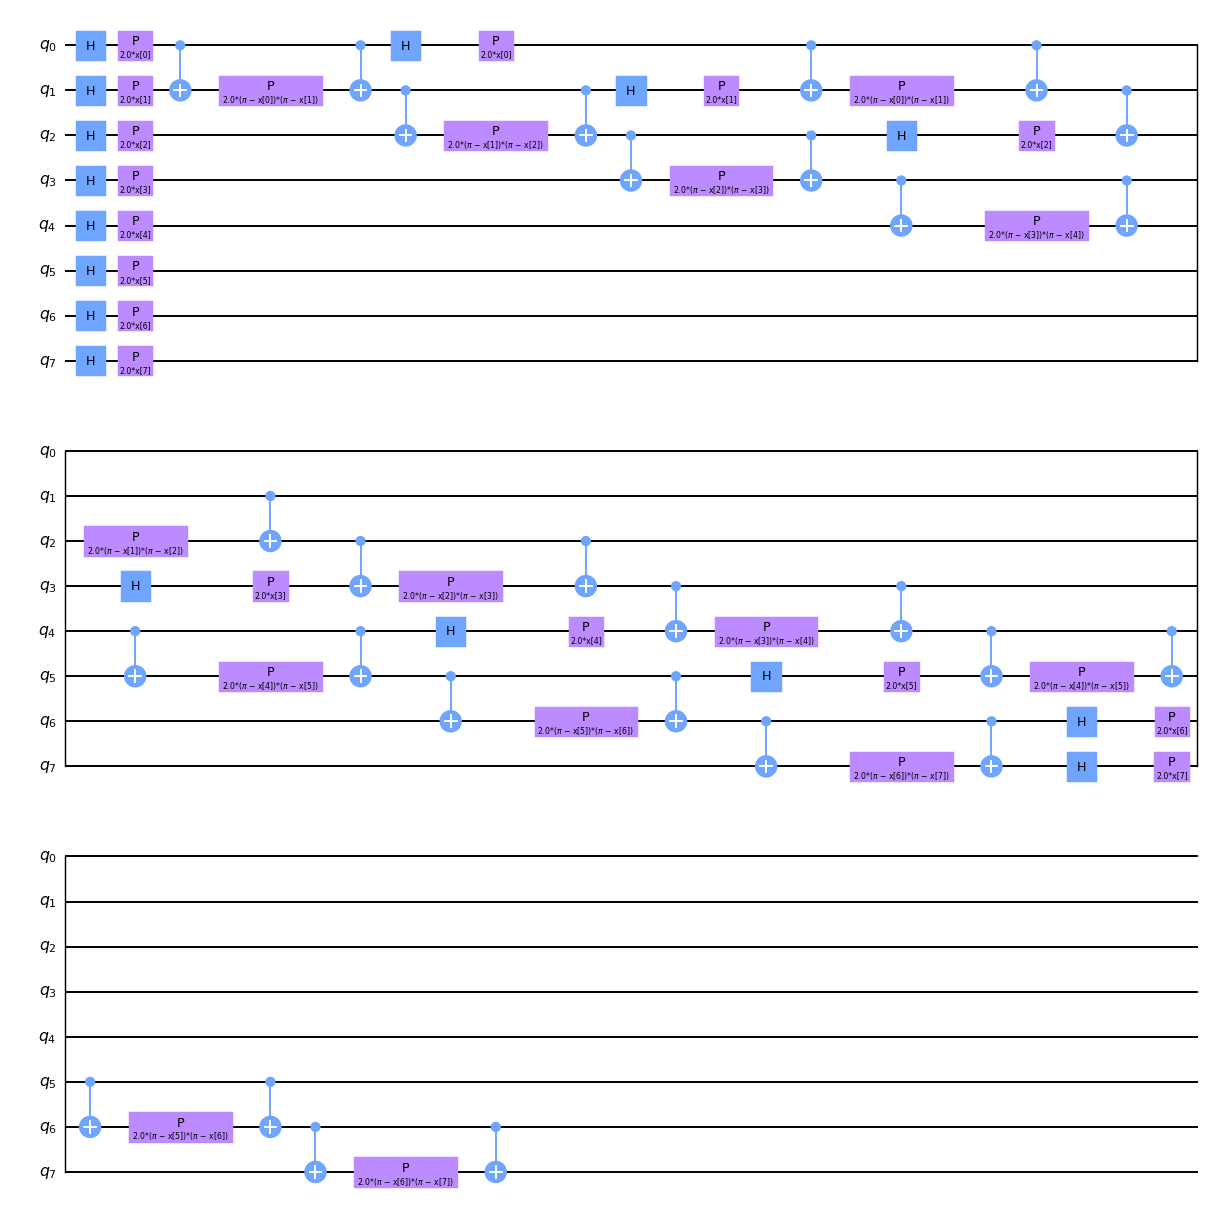

In [8]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(n_components_classic, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw('mpl', scale=0.7)

In [9]:
fmap_zz.parameters

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7])])

/opt/homebrew/Caskroom/miniforge/base/envs/qml-winterschool/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


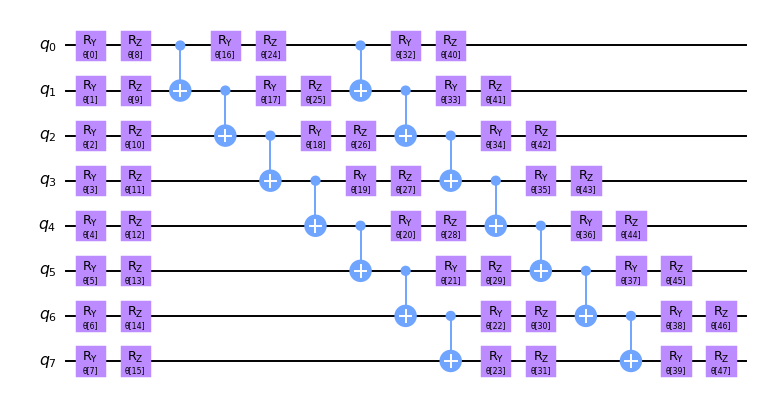

In [10]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz_tl = get_two_locals(n_components_classic, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz_tl.parameters
ansatz_tl.decompose().draw('mpl', scale=0.7)

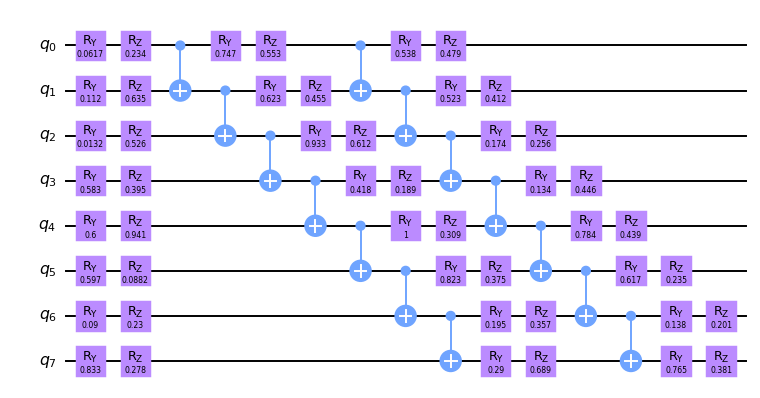

In [11]:
weights = np.random.random(len(ansatz_tl.parameters))
ansatz_tl.assign_parameters({k:v for (k,v) in zip(ansatz_tl.parameters, weights)}).decompose().draw('mpl', scale=0.7)

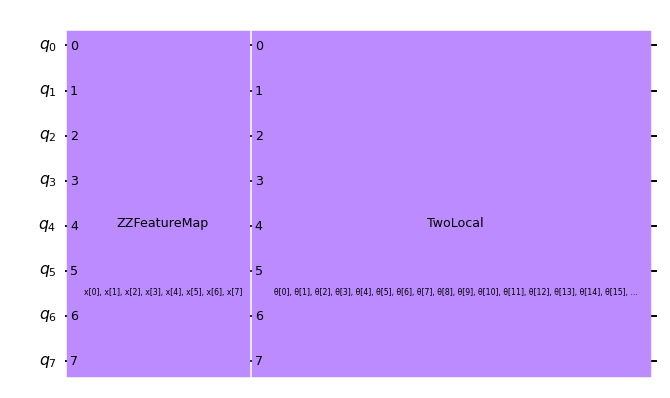

In [12]:
var_circuit = fmap_zz.compose(ansatz_tl)
var_circuit.draw('mpl', scale=0.7)

**Primitives**

For info, see https://docs.quantum.ibm.com/run/primitives

In [13]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
qasm_sim = AerSimulator()
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

**Quantum Neural Network**

**SamplerQNN**

In [14]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [15]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [16]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

**Forward pass**

In [17]:
# The result of the neural network on a forward pass.
output = sampler_qnn.forward(x_total, weights)
print(f"Output shape for {len(x_total)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 100 samples: (100, 2)
Output of the forward pass for first sample: [0.35351562 0.64648438]


**Backward pass**

In [18]:
# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(x_total, weights)
print(f"Output shape for {len(x_total)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")


Output shape for 100 samples: (100, 2, 48)
Output of the backward pass for first sample: [[ 0.20166016  0.01074219 -0.01220703  0.00927734  0.00634766  0.00585938
  -0.00683594  0.01171875  0.15527344  0.01367188 -0.02929688 -0.00830078
   0.01220703  0.00146484 -0.00439453  0.00488281 -0.11865234  0.01025391
  -0.01367188  0.01416016  0.00634766 -0.01611328 -0.00244141  0.02197266
  -0.12646484  0.08984375 -0.01416016 -0.01367188  0.01904297 -0.00976562
   0.01123047  0.02197266 -0.05615234 -0.00585938  0.         -0.00830078
   0.01953125 -0.00244141  0.01904297  0.00976562 -0.00537109  0.00830078
  -0.00048828 -0.015625   -0.00048828  0.01074219 -0.00292969  0.00732422]
 [-0.20166016 -0.01074219  0.01220703 -0.00927734 -0.00634766 -0.00585938
   0.00683594 -0.01171875 -0.15527344 -0.01367188  0.02929688  0.00830078
  -0.01220703 -0.00146484  0.00439453 -0.00488281  0.11865234 -0.01025391
   0.01367188 -0.01416016 -0.00634766  0.01611328  0.00244141 -0.02197266
   0.12646484 -0.08984

**EstimatorQNN**

In [19]:
obs_parity = Pauli('Z' * n_components_classic)
obs_one_qubit = Pauli('I' * (n_components_classic - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}")

Parity observable: ZZZZZZZZ
First qubit observable: IIIIIIIZ


In [20]:
paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator)

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=var_circuit,
                             observables=obs_one_qubit,
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

**Forward pass**

In [21]:
# The result of the neural network on a forward pass.
output = estimator_qnn.forward(x_total, weights)
print(f"Output shape for {len(x_total)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 100 samples: (100, 1)
Output of the forward pass for first sample: [-0.28515625]


**Backward pass**

In [22]:
# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(x_total, weights)
print(f"Output shape for {len(x_total)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

Output shape for 100 samples: (100, 1, 48)
Output of the backward pass for first sample: [[ 0.39355469  0.0078125  -0.06347656  0.01367188  0.01171875 -0.01074219
   0.02050781 -0.00195312  0.29199219  0.03417969 -0.09960938 -0.02832031
  -0.00390625  0.03125    -0.01855469 -0.04101562 -0.2265625   0.04394531
  -0.04589844  0.01464844 -0.01464844 -0.00195312 -0.05078125  0.01269531
  -0.34667969  0.1875     -0.0390625  -0.05957031  0.01464844 -0.04492188
   0.02246094  0.03027344 -0.09082031 -0.00390625 -0.00976562  0.01757812
  -0.01269531  0.00683594  0.00488281 -0.015625   -0.01855469 -0.02539062
   0.04199219 -0.02539062 -0.01660156  0.015625    0.02539062 -0.02246094]]


**Train a Neural Network Classifier**

In [23]:
y_train

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [24]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 1 converted to [0 1]
Label 0 converted to [1 0]


In [25]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [26]:
max_itr = 100
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)

vqc = vqc.fit(x_train_small_pca, y_train_1h)

In [27]:
vqc

In [29]:
np.save('spsa_loss_recorder.npy', spsa_loss_recorder)

Text(0.5, 1.0, 'Training loss')

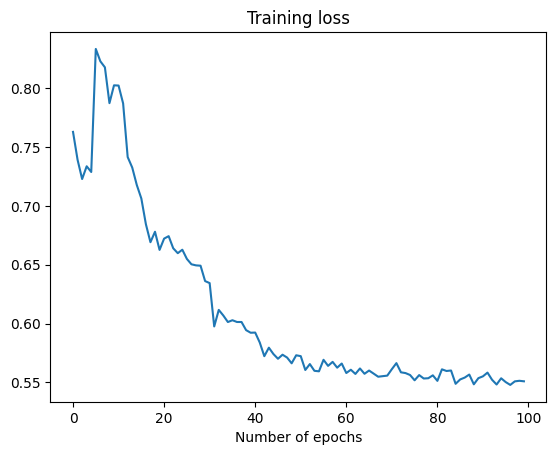

In [30]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [36]:
score_train = vqc.score(x_train_small_pca, y_train_1h)
score_test = vqc.score(x_test_small_pca, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.95
Score on the test set 0.85


In [37]:
y_train_pred = vqc.predict(x_train_small_pca)
y_test_pred = vqc.predict(x_test_small_pca)

In [38]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [39]:
x_all = np.concatenate((x_train_small_pca, x_test_small_pca))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [1, 0], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

x_r = x_all[np.all(y_all == [0, 1], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

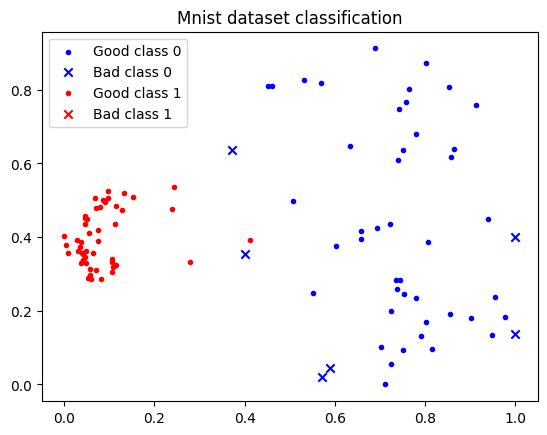

In [40]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Mnist dataset classification")
plt.legend()

**COBYLA optimizer**

In [25]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Number of epochs")
    plt.ylabel("Training loss")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


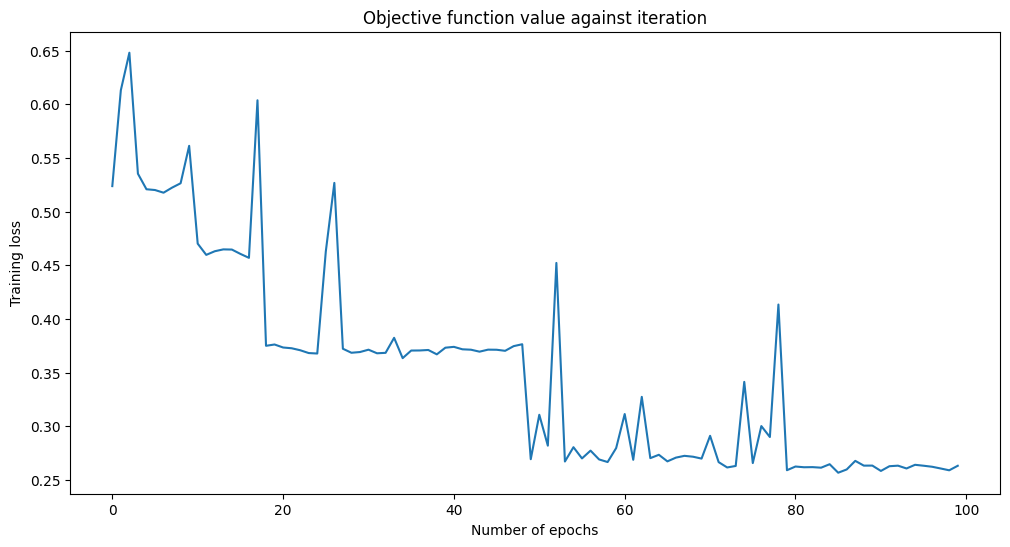

In [48]:
#max_itr = 10
#spsa_opt = COBYLA(callback=callback_graph)
objective_func_vals = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              #loss=CrossEntropyLoss(),
                              one_hot=True,
                              #optimizer=optimizer,
                              optimizer=COBYLA(maxiter=100),
                              #initial_point=initial_point,
                             callback=callback_graph)

vqc = vqc.fit(x_train_small_pca, y_train)

In [51]:
score_train = vqc.score(x_train_small_pca, y_train)
score_test = vqc.score(x_test_small_pca, y_test)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.925
Score on the test set 0.85


In [49]:
cobyla_objective_func_vals = objective_func_vals

In [50]:
np.save('cobyla_objective_func_vals.npy', cobyla_objective_func_vals)

**L_BFGS_B optimizer**

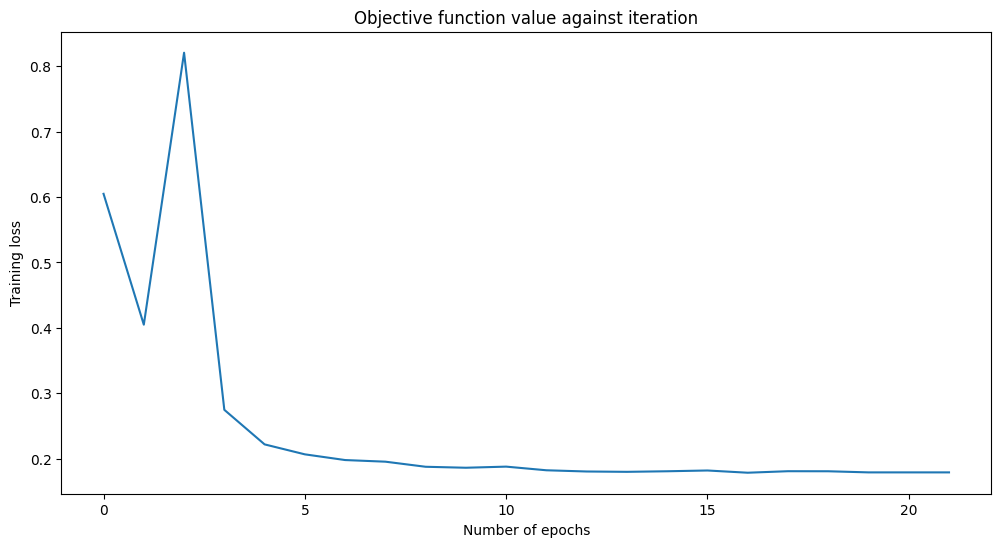

In [52]:
#max_itr = 10
#spsa_opt = COBYLA(callback=callback_graph)
objective_func_vals = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              #loss=CrossEntropyLoss(),
                              one_hot=True,
                              #optimizer=optimizer,
                              optimizer=L_BFGS_B(maxiter=100),
                              #initial_point=initial_point,
                             callback=callback_graph)

vqc = vqc.fit(x_train_small_pca, y_train)

In [53]:
score_train = vqc.score(x_train_small_pca, y_train)
score_test = vqc.score(x_test_small_pca, y_test)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.9625
Score on the test set 0.95


In [54]:
objective_func_vals

[0.6048114538192749,
 0.40487449169158934,
 0.8204205989837646,
 0.27476503849029543,
 0.2219707489013672,
 0.20675034523010255,
 0.19802265167236327,
 0.19553256034851074,
 0.1877533197402954,
 0.18626670837402343,
 0.18797333240509034,
 0.18239991664886473,
 0.1805337905883789,
 0.1800184965133667,
 0.18089160919189454,
 0.18207037448883057,
 0.1786609411239624,
 0.18097233772277832,
 0.18088583946228026,
 0.17917563915252685,
 0.17917563915252685,
 0.17917563915252685]

In [55]:
BFG_objective_func_vals = objective_func_vals

In [56]:
np.save('BFG_objective_func_vals.npy', BFG_objective_func_vals)

**SLSQP**

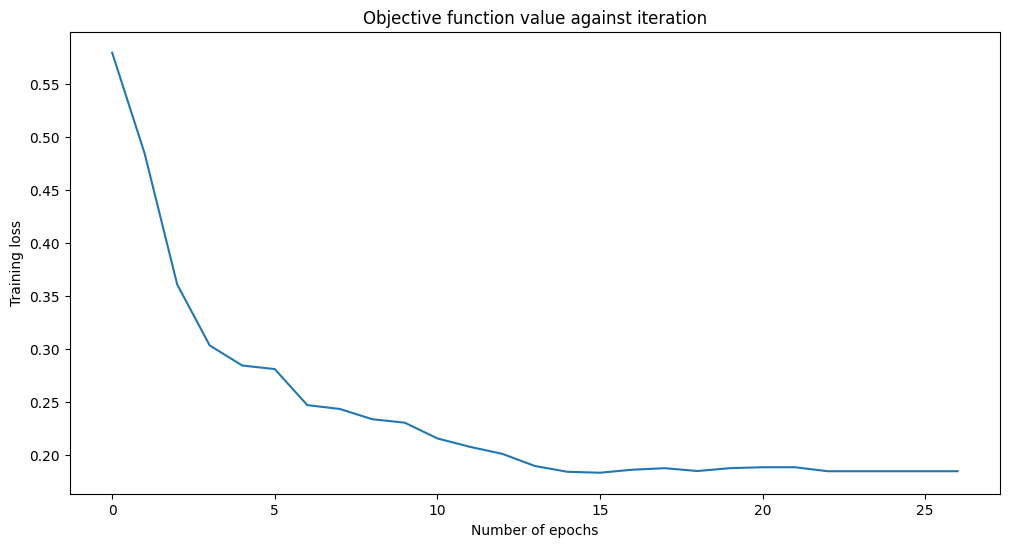

In [57]:
#max_itr = 10
#spsa_opt = COBYLA(callback=callback_graph)
objective_func_vals = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              #loss=CrossEntropyLoss(),
                              one_hot=True,
                              #optimizer=optimizer,
                              optimizer=SLSQP(maxiter=100),
                              #initial_point=initial_point,
                             callback=callback_graph)

vqc = vqc.fit(x_train_small_pca, y_train)

In [58]:
score_train = vqc.score(x_train_small_pca, y_train)
score_test = vqc.score(x_test_small_pca, y_test)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.9625
Score on the test set 0.9


In [59]:
SLSQP_objective_func_vals = objective_func_vals

In [60]:
np.save('SLSQP_objective_func_vals.npy', SLSQP_objective_func_vals)

**AQGD**

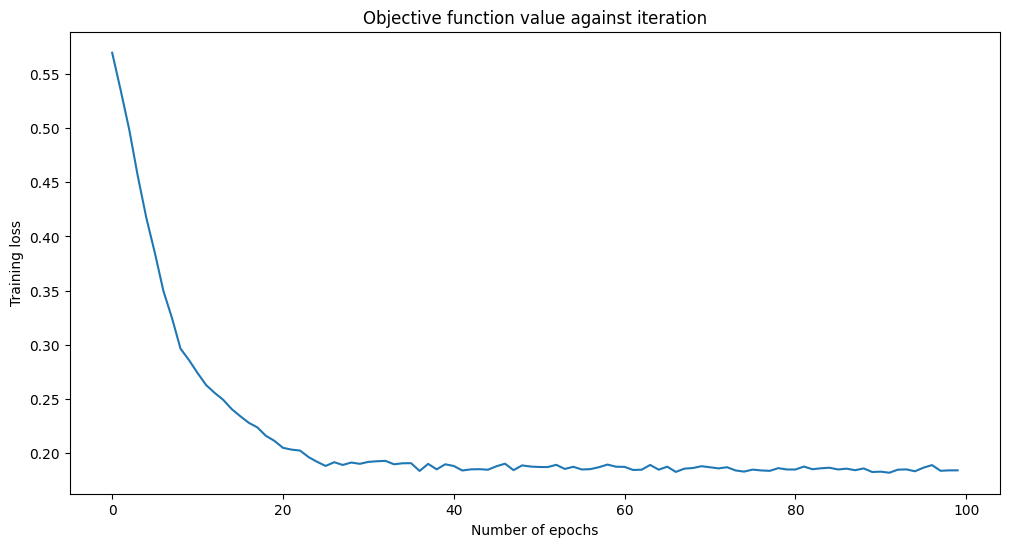

In [26]:
#max_itr = 10
#spsa_opt = COBYLA(callback=callback_graph)
objective_func_vals = []
initial_point = np.random.random((len(ansatz_tl.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              #loss=CrossEntropyLoss(),
                              one_hot=True,
                              #optimizer=optimizer,
                              optimizer=AQGD(maxiter=100),
                              #initial_point=initial_point,
                             callback=callback_graph)

vqc = vqc.fit(x_train_small_pca, y_train)

In [27]:
score_train = vqc.score(x_train_small_pca, y_train)
score_test = vqc.score(x_test_small_pca, y_test)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

Score on the train set 0.9625
Score on the test set 0.9


In [28]:
AQGD_objective_func_vals = objective_func_vals

In [29]:
np.save('AQGD_objective_func_vals.npy', AQGD_objective_func_vals)